# Machine Learning Assignment

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
from matplotlib import colors
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, validation_curve, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.tree import DecisionTreeClassifier as DTreeClass
from sklearn.metrics import accuracy_score, zero_one_loss, roc_auc_score, roc_curve, classification_report, f1_score
from scipy import stats

In [31]:
names = ['Sequence name','mcg','gvh','alm','mit','erl','pox','vac','nuc','class'];
data_yeast = pd.read_csv('yeast.data', header = None, sep = '\s+', names = names);
data_pima = pd.read_csv('diabetes.csv');


## Question 1

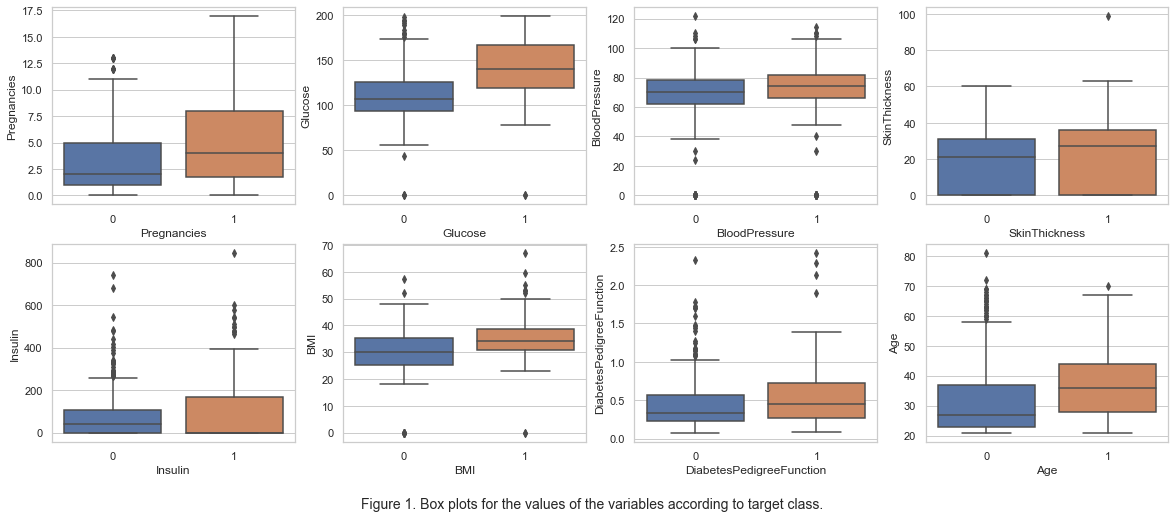

In [32]:
cols = data_pima.columns[:8]
fig, ax = plt.subplots(2,4, sharex=False, sharey=False, figsize=(20, 8))
txt="Figure 1. Box plots for the values of the variables according to target class."
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=14)
for i in range(len(cols)):
    sns.boxplot(ax=ax[i//4, i%4], y=cols[i], x='Outcome', data=data_pima)
    ax[i//4, i%4].set(xlabel=cols[i])
plt.show();

    Após análise aos gráficos apresentados, podemos observar rapidamente que as variáveis que melhor "separam" a variável alvo são a Glucose, BMI e Age. Contudo, as duas escolhidas (como requisitado pelo exercicio) foram a Glucose e BMI. A variável Age foi descartada pois tinha mais outliers.
    Uma vez feita a escolha, foram removidos alguns dados pois os mesmos representavam situação não reais (p.e. valores de glucose nulos).

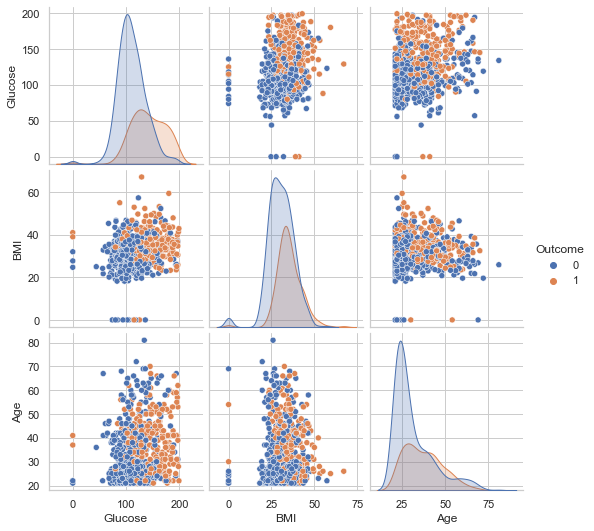

In [61]:
data_pima_sel = data_pima.drop(columns = ['BloodPressure', 'SkinThickness', 'Pregnancies', 'DiabetesPedigreeFunction', 'Insulin'])
sns.pairplot(data_pima_sel, hue = 'Outcome');

## Methods comparison (kNN, Logistic Regression, QDA)

In [34]:
data_pima_clean = data_pima_sel[(data_pima['Glucose'] != 0) & (data_pima['BMI'] != 0)]
data_pima_clean = data_pima_clean.sample(frac=1).reset_index(drop=True)

In [35]:
data_pima_sel_final = data_pima_clean.drop(columns = 'Age')
column_names = ['Glucose', 'BMI']
temp = data_pima_sel_final[column_names].values
temp_scaled = MinMaxScaler().fit_transform(temp)
data_pima_sel_final[column_names] = temp_scaled
X = data_pima_sel_final.drop(columns = 'Outcome').values
y = data_pima_sel_final.loc[:,'Outcome'].values
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123, stratify= y)

In [36]:
def plot_classifier_boundary(model,x,h = .05): #kindly provided in class
    cmap_light = colors.ListedColormap(['lightsteelblue', 'peachpuff'])
    x_min, x_max = x[:, 0].min()-.2, x[:, 0].max()+.2
    y_min, y_max = x[:, 1].min()-.2, x[:, 1].max()+.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=cmap_light)
    plt.xlim((x_min,x_max))
    plt.ylim((y_min,y_max))
cmap = colors.ListedColormap(['blue','orange'])

In [37]:
def StratKF(model, splits,x_train, y_train, x_test, y_test): #fitted model necessary
    SKF = StratifiedKFold(n_splits=splits, shuffle=True, random_state=1)
    score = []
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)
    for train_index, test_index in SKF.split(x_test, y_test):
        x_test1 = x_train[test_index]
        y_test1 = y_train[test_index]
        score.append(f1_score(y_test1, model.predict(x_test1)))
    print(f'F1 score on {splits}-fold test data: ',round(np.mean(score),4),'+/-', round(np.std(score),4))
    print('F1 score on training set: ',round(f1_score(y_train, y_pred_train),4), '\nF1 score on test set: ',round(f1_score(y_test, y_pred_test), 4))

### Logistic Regression

In [38]:
modelLogReg = LogReg()
modelLogReg.fit(x_train, y_train)
StratKF(modelLogReg,5, x_train, y_train, x_test, y_test)

F1 score on 5-fold test data:  0.524 +/- 0.1142
F1 score on training set:  0.6067 
F1 score on test set:  0.5116


### Quadratic Discriminant Analysis

In [39]:
modelQDA = QDA()
modelQDA.fit(x_train, y_train)
StratKF(modelQDA,5, x_train, y_train, x_test, y_test)

F1 score on 5-fold test data:  0.5145 +/- 0.0953
F1 score on training set:  0.6458 
F1 score on test set:  0.5169


### kNN

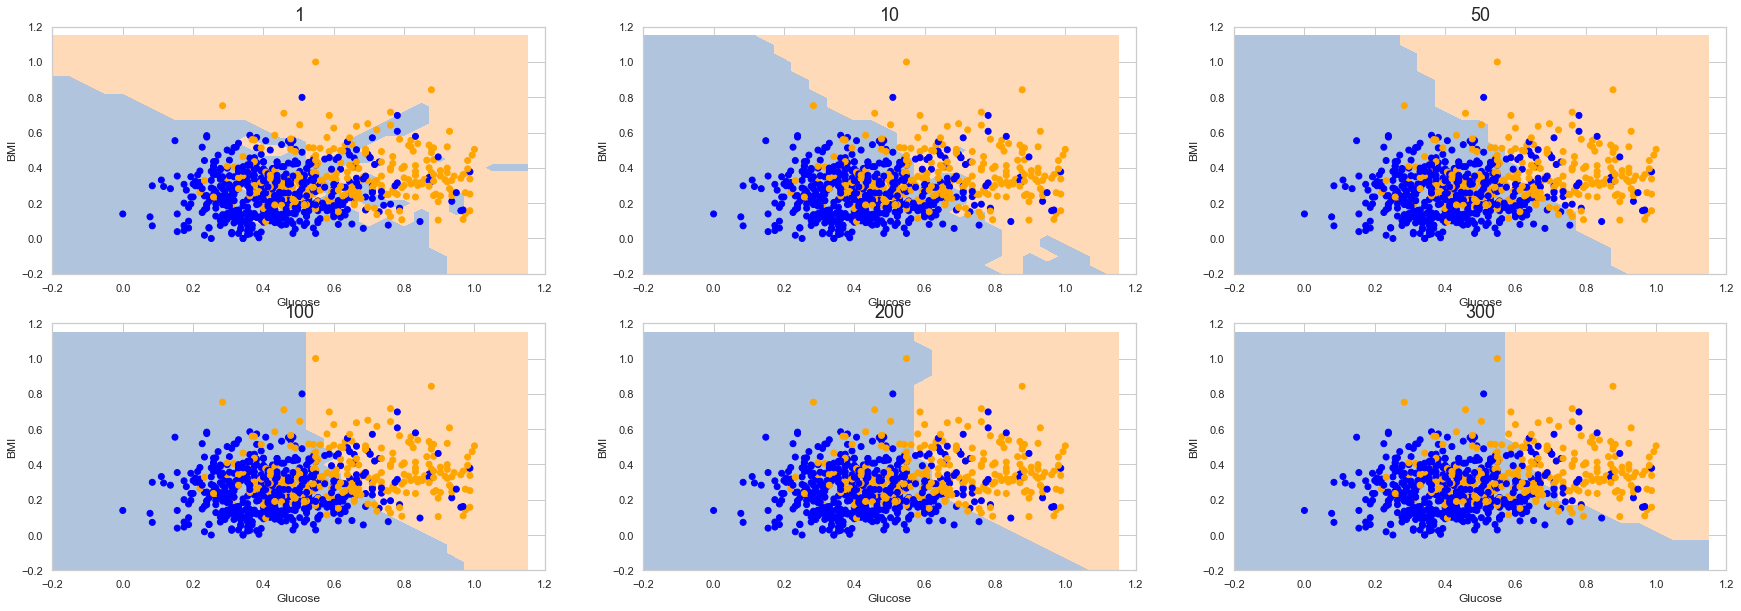

In [40]:
fig = plt.figure(figsize=(30,10))
k = [1,10,50,100,200,300]
for i in range(len(k)):
    modelkNN = kNN(n_neighbors=k[i])
    modelkNN.fit(x_train, y_train)
    ax = fig.add_subplot(2, 3, i+1)
    plot_classifier_boundary(modelkNN, X)
    ax.scatter(X[:,0],X[:,1],color=cmap(y))
    ax.set_title(k[i], fontsize = 18)
    ax.set_xlabel('Glucose')
    ax.set_ylabel('BMI');

In [41]:
def valid_curve(model, x_train, y_train, n_jobs, scoring, param_range = np.array([*range(1,301)]), param_name="n_neighbors"):
    np.random.seed(1)
    train_scores, test_scores = validation_curve(model, x_train, y_train, param_name=param_name, param_range=param_range, scoring=scoring, n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.figure(figsize=(20, 8))
    plt.title("kNN Validation Curve")
    plt.xlabel("k Neighbors")
    plt.ylabel("Score")
    plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange")
    plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="darkorange")
    plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="navy")
    plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="navy")
    plt.legend(loc="best")
    plt.show();
    print("Best K is %d" %param_range[np.where(test_scores_mean == max(test_scores_mean))][0])
    return param_range[np.where(test_scores_mean == max(test_scores_mean))][0]

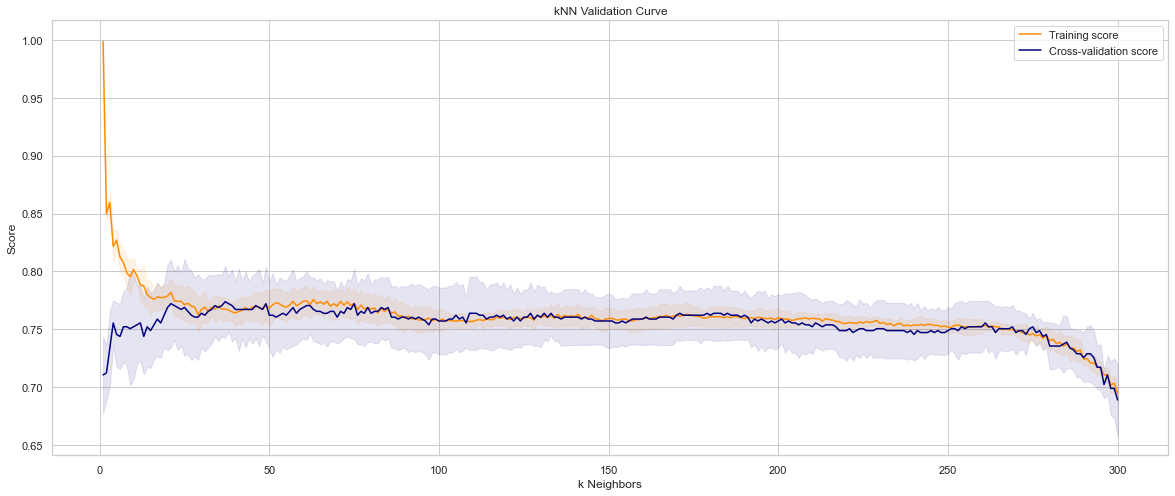

Best K is 37


In [42]:
modelkNN = kNN()
k_best = valid_curve(modelkNN, x_train, y_train, 6, 'accuracy')

In [43]:
modelkNN = kNN(n_neighbors=k_best)
modelkNN.fit(x_train, y_train)
StratKF(modelkNN,5, x_train, y_train, x_test, y_test)

F1 score on 5-fold test data:  0.5293 +/- 0.1105
F1 score on training set:  0.6273 
F1 score on test set:  0.5227


In [44]:
#ROC AUC
ns_probs = [0 for _ in range(len(y_test))]
# probabilities for the positive outcome
LogReg_probs = modelLogReg.predict_proba(x_test)[:, 1]
QDA_probs = modelQDA.predict_proba(x_test)[:, 1]
kNN_probs = modelkNN.predict_proba(x_test)[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
LogReg_auc = roc_auc_score(y_test, LogReg_probs)
QDA_auc = roc_auc_score(y_test, QDA_probs)
kNN_auc = roc_auc_score(y_test, kNN_probs)
# summarize scores
#print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LR ROC AUC=%.3f' % (LogReg_auc))
print('QDA ROC AUC=%.3f' % (QDA_auc))
print('kNN ROC AUC=%.3f' % (kNN_auc))

LR ROC AUC=0.751
QDA ROC AUC=0.746
kNN ROC AUC=0.759


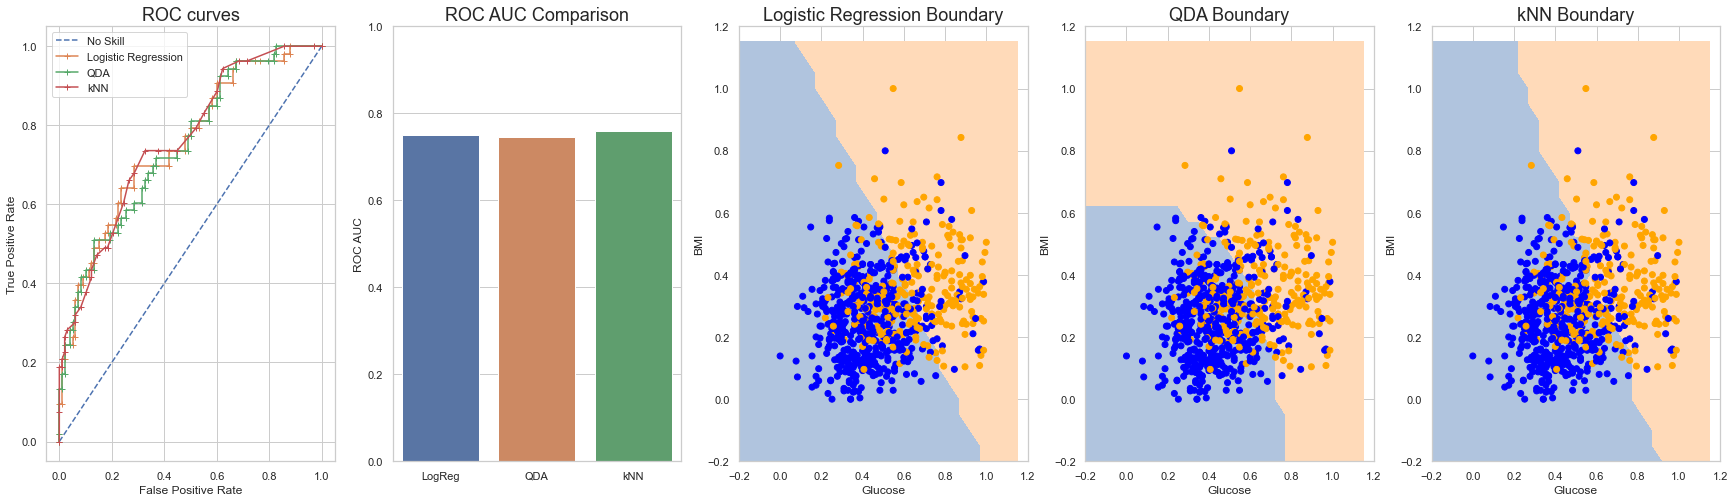

In [45]:
#ROC curves
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs, pos_label=None)
LogReg_fpr, LogReg_tpr, _ = roc_curve(y_test, LogReg_probs)
QDA_fpr, QDA_tpr, _ = roc_curve(y_test, QDA_probs)
kNN_fpr, kNN_tpr, _ = roc_curve(y_test, kNN_probs)
figs = plt.figure(figsize=(30,8))
# plot the roc curves
axs = figs.add_subplot(1, 5, 1)
axs.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
axs.plot(LogReg_fpr,LogReg_tpr, marker='+', label='Logistic Regression')
axs.plot(QDA_fpr,QDA_tpr, marker='+', label='QDA')
axs.plot(kNN_fpr,kNN_tpr, marker='+', label='kNN')
axs.set_xlabel('False Positive Rate')
axs.set_ylabel('True Positive Rate')
axs.set_title('ROC curves', fontsize = 18)
axs.legend();
##Barplot of AUCs
axs = figs.add_subplot(1, 5, 2)
sns.barplot(y=[LogReg_auc,QDA_auc,kNN_auc], x=['LogReg', 'QDA', 'kNN'], ax=axs)
axs.set_ylim(0,1)
axs.set_title('ROC AUC Comparison', fontsize = 18)
axs.set_ylabel('ROC AUC');
model_list = [(modelLogReg,'Logistic Regression Boundary') , (modelQDA, 'QDA Boundary'), (modelkNN, 'kNN Boundary')]
for i in range(3,6,1):
    axs = figs.add_subplot(1, 5, i)
    plot_classifier_boundary(model_list[i-3][0],X)
    axs.scatter(X[:,0],X[:,1],color=cmap(y))
    axs.set_xlabel('Glucose')
    axs.set_ylabel('BMI');
    axs.set_title(model_list[i-3][1], fontsize = 18)
plt.show();

    Nesta análise comparámos os três modelos directamente (o kNN foi alvo de ajuste de hiperparâmetros, recorrendo à análise do gráfico acima representado). Embora restantes modelos não possuem hiperparâmetros, e como o dados foram normalizados antes dos respectivos treinos, podemos supor que tiveram melhor rendimento ao invês de um possível treino sem normalização. Podemos observar que ambos os modelos obtêm um valor de AUC semelhante, a rondar os 75%.
    Observando as "linhas de fronteira" obtidas vemos rapidamente a semelhança entre a regressão logistica e o kNN, o que seria de esperar dado o valor elevado do k, bem como o valor quase idêntico do AUC. Relativamente à QDA, a fronteira obtida não se assemelha a uma linearização, mas sim a uma quadratização da linha. Não é um modelo tão flexível como o kNN, mas é alguns casos é possível que tenha um melhor comportamento devido à abordagem quadrática.

## Question 2

### normalization

In [46]:
MinMaxSca = MinMaxScaler()
data_yeast[['mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc']] = MinMaxSca.fit_transform(data_yeast.loc[:,['mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc']])

### Separation in train data and test data

In [47]:
X = data_yeast.loc[:, ['mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc']].values
Y = data_yeast.loc[:,'class'].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1, stratify = Y, shuffle=True)
SKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [48]:
def StratKFW(model, splits, X_train, Y_train, X_test, Y_test):
    Y_pred_trainLogReg = model.predict(X_train)
    Y_pred_testLogReg = model.predict(X_test)
    print('Weighted F1 score on training set: ',round(f1_score(Y_train, Y_pred_trainLogReg, average='weighted'),4), 
        '\nWeighted F1 score on test set: ',round(f1_score(Y_test, Y_pred_testLogReg, average='weighted'), 4))
    f1score = []
    accscore = []
    for train_index, test_index in SKF.split (X_test, Y_test):
        X_test1 = X_test[test_index]
        Y_test1 = Y_test[test_index]
        f1score.append(f1_score(Y_test1, model.predict(X_test1), average='weighted'))
        accscore.append(accuracy_score(Y_test1, model.predict(X_test1)))
    print(f'Weighted F1 score on {splits}-fold test data: ',round(np.mean(f1score_LogReg),4),'+/-', round(np.std(f1score_LogReg),4))
    print('\nClassification report:\n',classification_report(Y_test, Y_pred_testLogReg, digits=3))
    return f1score, accscore

### Logistic regression

In [49]:
modelLR = LogReg()
modelLR.fit(X_train, Y_train)
f1score_LogReg, accscore_LogReg = [], []
f1score_LogReg, accscore_LogReg = StratKFW(modelLR, 5, X_train, Y_train, X_test, Y_test)

Weighted F1 score on training set:  0.5564 
Weighted F1 score on test set:  0.5406
Weighted F1 score on 5-fold test data:  nan +/- nan

Classification report:
               precision    recall  f1-score   support

         CYT      0.504     0.742     0.600        93
         ERL      0.000     0.000     0.000         1
         EXC      0.000     0.000     0.000         7
         ME1      0.455     0.556     0.500         9
         ME2      0.000     0.000     0.000        10
         ME3      0.667     0.688     0.677        32
         MIT      0.617     0.592     0.604        49
         NUC      0.631     0.477     0.543        86
         POX      0.667     0.500     0.571         4
         VAC      0.000     0.000     0.000         6

    accuracy                          0.566       297
   macro avg      0.354     0.355     0.350       297
weighted avg      0.537     0.566     0.541       297



### kNN

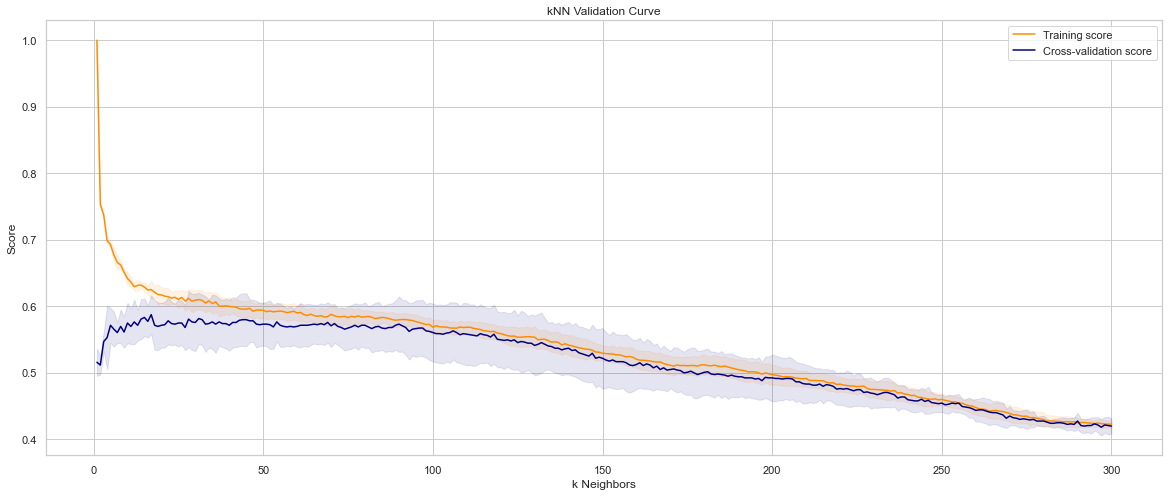

Best K is 17


In [50]:
k_best = valid_curve(modelkNN, X_train, Y_train, 6, 'accuracy')

In [51]:
modelknn = kNN(n_neighbors=k_best)
modelknn.fit(X_train, Y_train)
f1score_knn, accscore_knn = [], []
f1score_knn, accscore_knn = StratKFW(modelknn, 5, X_train, Y_train, X_test, Y_test)

Weighted F1 score on training set:  0.6207 
Weighted F1 score on test set:  0.5658
Weighted F1 score on 5-fold test data:  0.5383 +/- 0.0319

Classification report:
               precision    recall  f1-score   support

         CYT      0.526     0.656     0.584        93
         ERL      0.000     0.000     0.000         1
         EXC      0.667     0.571     0.615         7
         ME1      0.462     0.667     0.545         9
         ME2      0.333     0.200     0.250        10
         ME3      0.719     0.719     0.719        32
         MIT      0.681     0.653     0.667        49
         NUC      0.554     0.477     0.513        86
         POX      0.667     0.500     0.571         4
         VAC      0.000     0.000     0.000         6

    accuracy                          0.576       297
   macro avg      0.461     0.444     0.446       297
weighted avg      0.565     0.576     0.566       297



### Decision tree

In [52]:
modeltree = DTreeClass()
modeltree.fit(X_train, Y_train)
f1score_tree, accscore_tree = [], []
f1score_tree, accscore_tree = StratKFW(modeltree, 5, X_train, Y_train, X_test, Y_test)

Weighted F1 score on training set:  1.0 
Weighted F1 score on test set:  0.4973
Weighted F1 score on 5-fold test data:  0.5383 +/- 0.0319

Classification report:
               precision    recall  f1-score   support

         CYT      0.515     0.548     0.531        93
         ERL      0.000     0.000     0.000         1
         EXC      0.300     0.429     0.353         7
         ME1      0.727     0.889     0.800         9
         ME2      0.111     0.100     0.105        10
         ME3      0.688     0.688     0.688        32
         MIT      0.556     0.408     0.471        49
         NUC      0.489     0.500     0.494        86
         POX      0.000     0.000     0.000         4
         VAC      0.000     0.000     0.000         6

    accuracy                          0.498       297
   macro avg      0.339     0.356     0.344       297
weighted avg      0.501     0.498     0.497       297



In [53]:
def model_grid_search(model, param_grid, cv, scoring, n_jobs): # "cv - integer, to specify the number of folds in a `(Stratified) KFold`,"
    model_grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = cv, refit = True, scoring= scoring, n_jobs = n_jobs)
    model_grid.fit(X_train, Y_train)
    print(f"Best estimator: {model_grid.best_estimator_} \n  Best score: {model_grid.best_score_} \n Best Params: {model_grid.best_params_}")
    return model_grid.best_estimator_

In [54]:
max_depth = [None] + [x for x in np.arange(1,20,4)]
min_sample_split= np.arange(2, 10,2)
min_sample_leaf = np.arange(1,5)
ccp_alpha = np.arange(0.01,100, 10)
param_grid_tree = {"criterion": ['gini', "entropy"],\
              "splitter": ['best',"random"],\
              "max_depth": max_depth,\
              "min_samples_split": min_sample_split,\
              "min_samples_leaf": min_sample_leaf, \
              "ccp_alpha": ccp_alpha}

In [55]:
tree_grid = model_grid_search(modeltree, param_grid_tree, 5, "f1_weighted", 2) 

Best estimator: DecisionTreeClassifier(ccp_alpha=0.01, criterion='entropy', max_depth=5,
                       min_samples_leaf=4, min_samples_split=4) 
  Best score: 0.5669393207369835 
 Best Params: {'ccp_alpha': 0.01, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 4, 'splitter': 'best'}


In [56]:
modeltree = tree_grid
f1score_tree, accscore_tree = StratKFW(modelLR, 5, X_train, Y_train, X_test, Y_test)

Weighted F1 score on training set:  0.5564 
Weighted F1 score on test set:  0.5406
Weighted F1 score on 5-fold test data:  0.5383 +/- 0.0319

Classification report:
               precision    recall  f1-score   support

         CYT      0.504     0.742     0.600        93
         ERL      0.000     0.000     0.000         1
         EXC      0.000     0.000     0.000         7
         ME1      0.455     0.556     0.500         9
         ME2      0.000     0.000     0.000        10
         ME3      0.667     0.688     0.677        32
         MIT      0.617     0.592     0.604        49
         NUC      0.631     0.477     0.543        86
         POX      0.667     0.500     0.571         4
         VAC      0.000     0.000     0.000         6

    accuracy                          0.566       297
   macro avg      0.354     0.355     0.350       297
weighted avg      0.537     0.566     0.541       297



### Achieved results comparison

In [57]:
stats_f1,pvalue_f1 = stats.f_oneway(f1score_LogReg, f1score_knn, f1score_tree)
stats_acc, pvalue_acc = stats.f_oneway(accscore_LogReg, accscore_knn, accscore_tree)

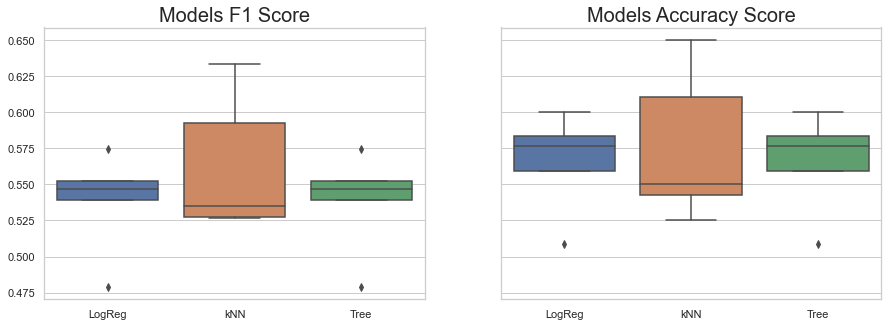

In [58]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True)
sns.set_theme(style="whitegrid")
ax[0].set_title('Models F1 Score', fontsize = 20)
ax[1].set_title('Models Accuracy Score', fontsize = 20)
sns.boxplot(y=f1score_LogReg + f1score_knn + f1score_tree, x=['LogReg']*5+['kNN']*5+['Tree']*5, ax=ax[0])
sns.boxplot(y=accscore_LogReg + accscore_knn + accscore_tree, x=['LogReg']*5+['kNN']*5+['Tree']*5, ax=ax[1]);